# 鄰近規則分析（K-Nearest Neighbors）

## 實作練習

### **Part 1 KNN實作：葡萄酒品種分類**

這次使用的是scikit-learn的葡萄酒化學成分的資料。
資料集連結：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html  

總共有176筆資料，每筆資料包含13個特徵（葡萄酒中不同成分的含量），共有三種葡萄酒

輸入特徵：
- Alcohol：酒精濃度
- Malic acid：頻果酸
- Ash：灰分
- Alcalinity of ash：灰分的鹼性
- Magnesium：鎂
- Total phenols：總酚
- Flavanoids：類黃酮
- Nonflavanoid phenols：非類黃酮酚
- Proanthocyanins：原花青素
- Color intensity：顏色深淺
- Hue：色相
- OD280/OD315 of diluted wines：稀釋酒的蛋白質含量
- Proline：脯胺酸

輸出：
三種不同品種的葡萄酒
- Class 0
- Class 1
- Class 2

我們的目標是利用這些資料訓練KNN模型，把葡萄酒進行分類。  

In [5]:
#1 載入資料集
from sklearn.datasets import load_wine
import pandas as pd

data = load_wine(as_frame=True)

# 轉成DataFrame並展示資料
df_data = data.frame
display(df_data)

# 提取輸入特徵、輸出變數
X = data['data']
y = data['target']

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


### 資料視覺化

保持好習慣，觀察一下資料分布狀況

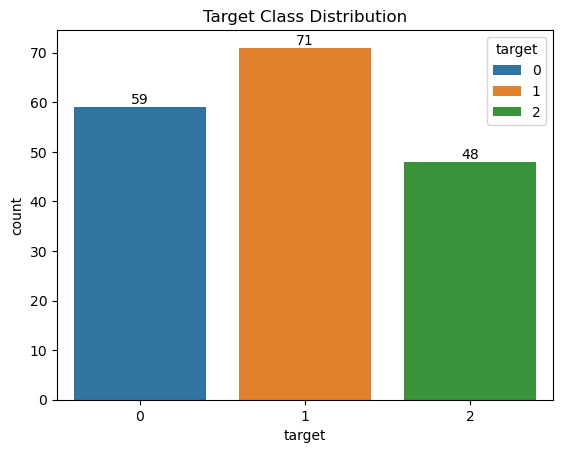

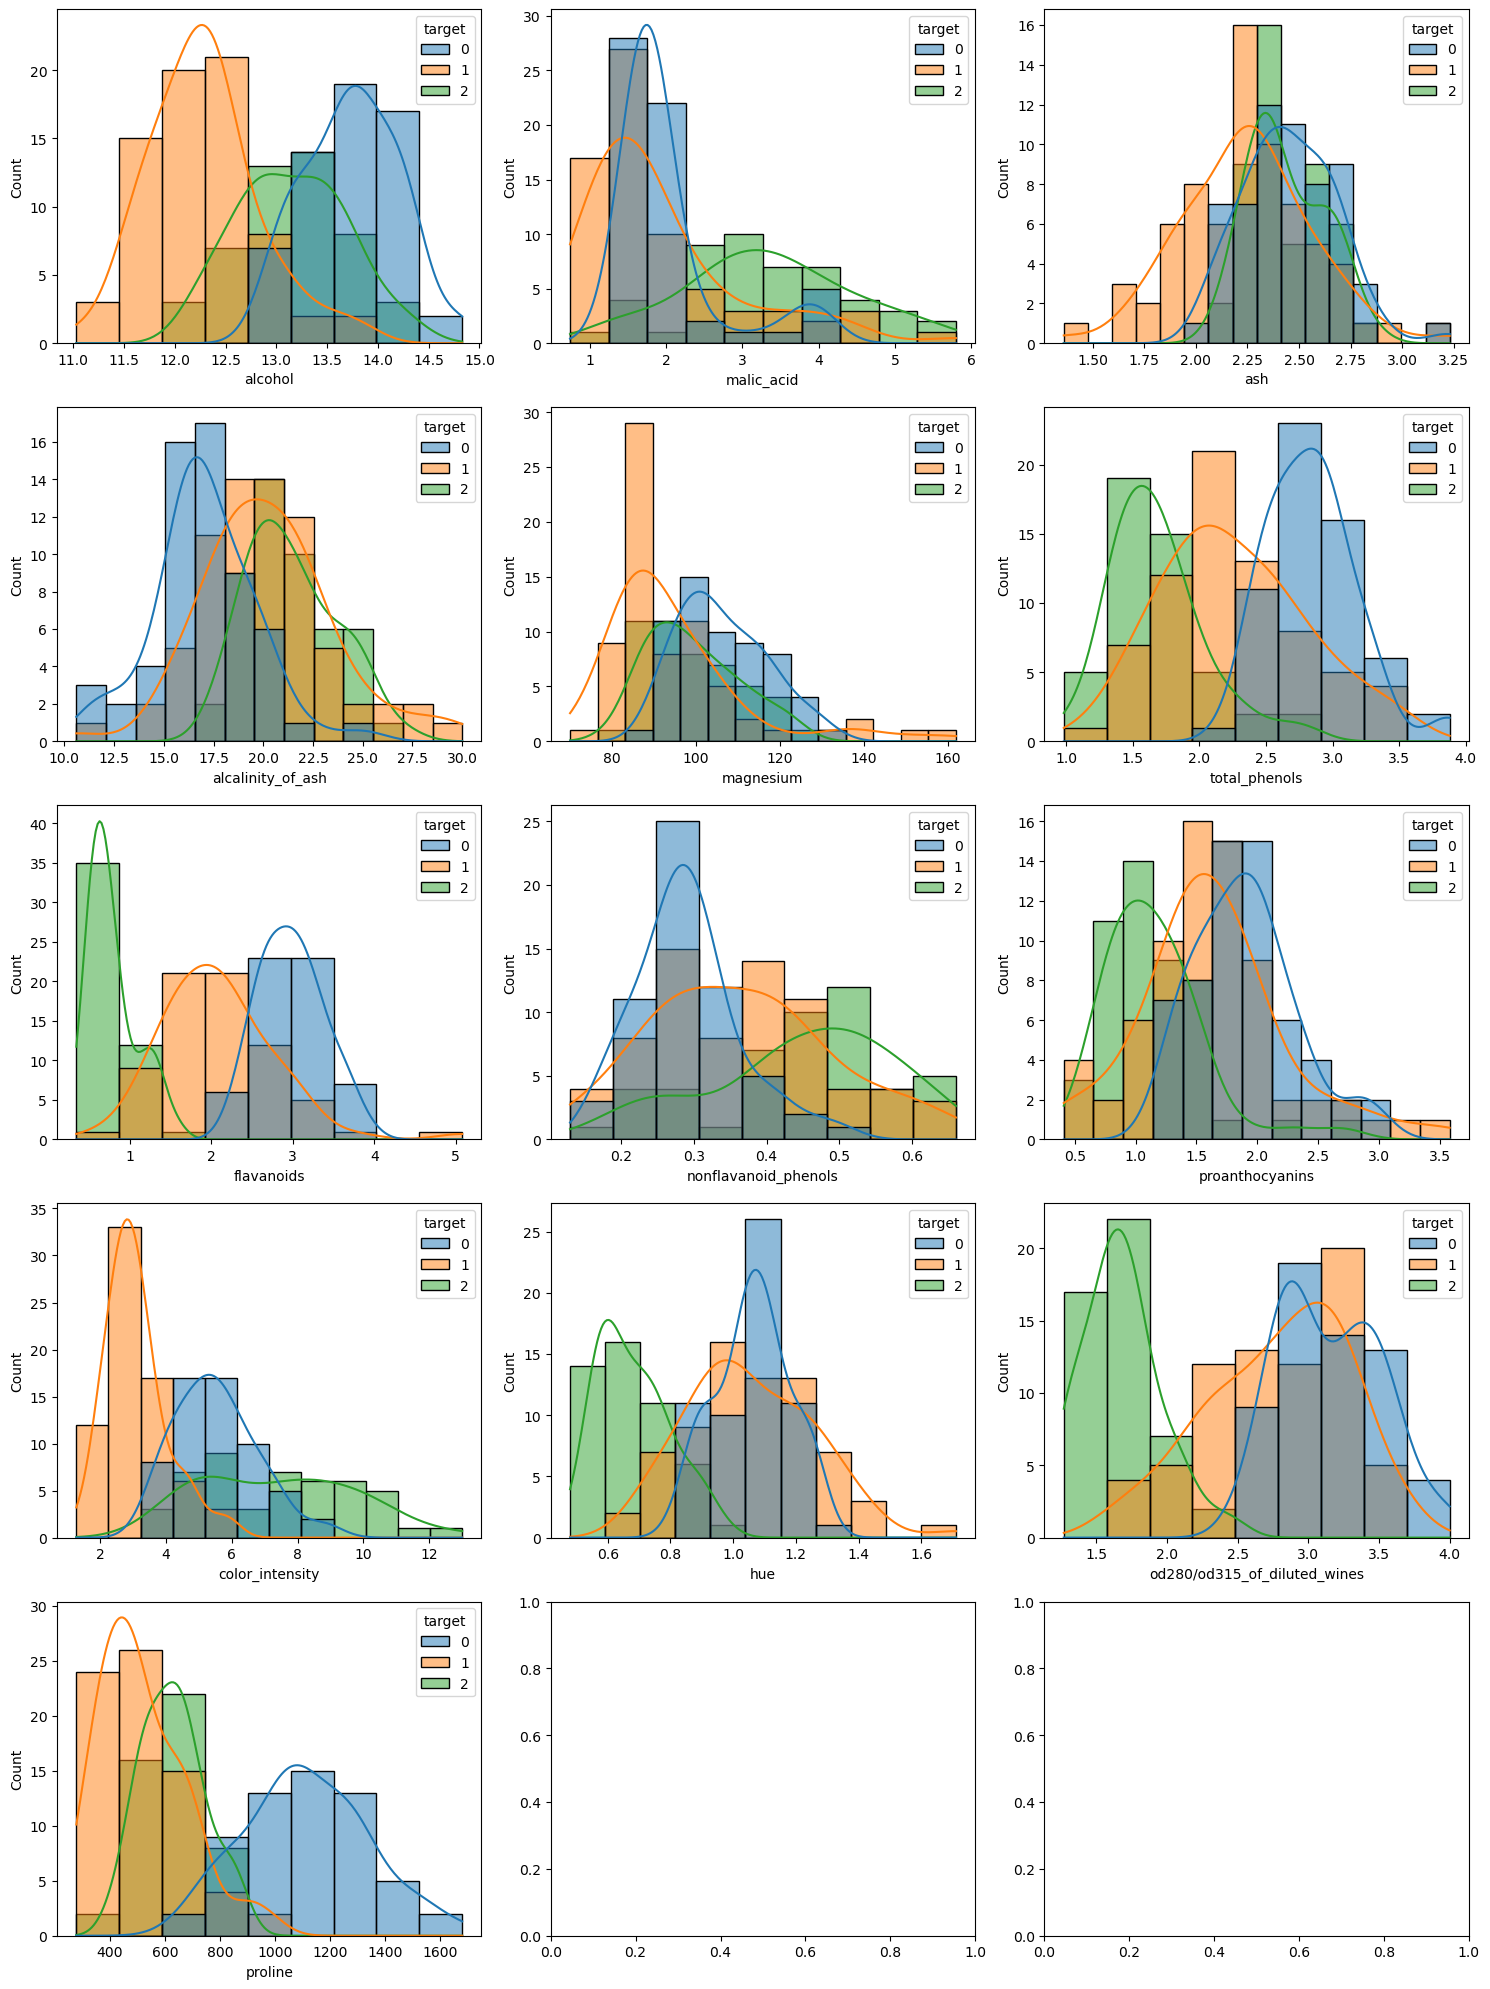

In [12]:
#2 觀察資料統計分布
import matplotlib.pyplot as plt
import seaborn as sns

# 繪製種類的直方圖
ax = sns.countplot(data=df_data, x='target', hue='target', palette='tab10')

# 繪製統計數量
for container in ax.containers:
    ax.bar_label(container)

plt.title("Target Class Distribution")

# 繪製各個特徵的直方圖
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
x_feature_names = data['feature_names']
for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, hue='target', kde=True, palette='tab10', ax=ax)
    
plt.tight_layout()
plt.show()

觀察圖表可以發現：
- 三個不同類別的數量沒有差太多
- Alcohol, Total phenols, Flavanoids在不同種酒間的差異特別明顯，可以用來區分不同的酒
- 各個特徵的數值範圍不同，需要進行標準化

### 分割資料

同樣以6\:2:2的比例把資料分割成訓練、驗證、測試集

In [16]:
#3 分割資料
from sklearn.model_selection import train_test_split

# 先分出測試集
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再分訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print('Train shape:', X_train.shape)
print('Validation shape:', X_val.shape)
print('Test shape:', X_test.shape)

Train shape: (106, 13)
Validation shape: (36, 13)
Test shape: (36, 13)


### 資料前處理

如同我們剛剛觀察到的，需要對資料進行標準化

In [20]:
#4 特徵標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

### 建立模型

接著建立、訓練KNN模型並將其用於預測

In [23]:
#5 建立KNN分類模型
from sklearn.neighbors import KNeighborsClassifier

# 建立模型，設定k = 3
knn_model = KNeighborsClassifier(n_neighbors=3)

# 訓練模型
knn_model.fit(X_train, y_train)

# 用模型預測
y_train_pred = knn_model.predict(X_train)
y_val_pred   = knn_model.predict(X_val)
y_test_pred  = knn_model.predict(X_test)

### 評估模型訓練結果

我們可以透過分數和繪製混淆矩陣來評估

In [26]:
#6 用分數評估模型的訓練結果

print("Train accuracy:", knn_model.score(X_train, y_train))
print("Validation accuracy:", knn_model.score(X_val, y_val))
print("Test accuracy:", knn_model.score(X_test, y_test))

Train accuracy: 0.9811320754716981
Validation accuracy: 0.9444444444444444
Test accuracy: 0.9444444444444444


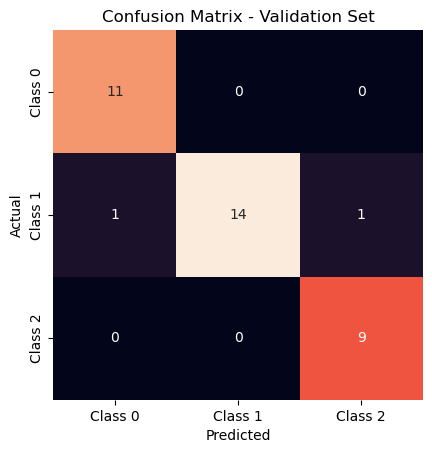

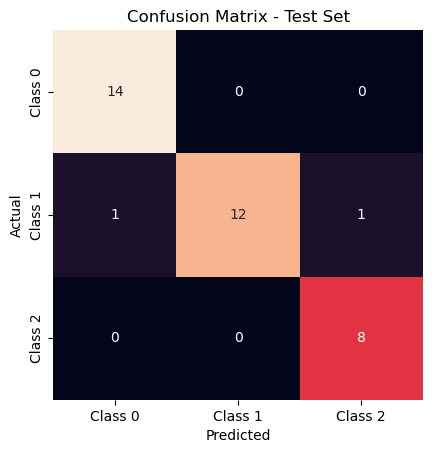

In [58]:
#7 用混淆矩陣觀察模型預測結果
def plot_confusion_matrix(actual, pred, labels):
    # 生成混淆矩陣
    confusion_matrix = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])

    # 將混淆矩陣用熱圖繪製出來
    sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, square=True, annot=True, cbar=False)

# 驗證集
y_label_names = ['Class 0', 'Class 1', 'Class 2']
plot_confusion_matrix(y_val, y_val_pred, labels=y_label_names)
plt.title("Confusion Matrix - Validation Set")
plt.show()

# 測試集
plot_confusion_matrix(y_test, y_test_pred, labels=y_label_names)
plt.title("Confusion Matrix - Test Set")
plt.show()

結果可以發現：
- 整體準確度很高
- 在驗證集和測試集中，模型對於Class 0和Class 2的預測結果都非常好，但Class 1有2個分類錯誤

我的解釋：
- 在Hue, Flavanoids, Nonflavanoid_phenols, Preanthocyanins, Total_phenols, Alcalinity_of_ash等類別中，類別1的數值都界在兩者之間，在某些特徵中又有和其中一個（
  或兩個）重疊範圍的現象，所以比較難分辨
- 類別1的數量本來就最多，所以分類出錯的機率自然也比另外兩個類別高